# Wumpus World Unity Environment Log Analysis

This notebook contains our analysis of performance logs from different AI agent implementations in the Wumpus World Unity environment.

We compare execution times and behavioral patterns across multiple scenarios with varying complexity.

## Context

The analysis focuses on different AI types including:
- Basic Rule-based agents
- Finite State Machine agents
- Behavior Tree agents
- Prolog agents
- Prolog Meta Interpreter agents

Each scenario uses different configurations of world size, number of agents, and dangers (pits and Wumpus) distribution.

Common parameters across all configurations:
| Parameter | Value |
|:----------|:------|
| **randomSeed** | 1 |
| **nbGold** | 1 |
| **nbAgent** | [1, 5, 10] |
| **aiType** | [Basic, FiniteStateMachine, BehaviorTree, Prolog, PrologMetaInterpreter] |
| **personalities** | [(cupid & brave), (ascetic & coward), (cupid & coward)] |

### Grid-Specific Configurations

| Grid Size | Number of Pits & Wumpus |
|:---------:|:-------------:|
| 10x10     | 3          |
| 15x15     | 7          |
| 20x20     | 12         |
| 25x25     | 19         |
| 30x30     | 27         |
| 50x50     | 75         |
| 100x100   | 300        |

We have 7 grid sizes, 3 personality sets, 5 AI types, and 3 agent numbers.

So, there are `7*3*5*3=315` configurations.

#### Prolog Meta Interpreter Limitations
However, we have 45 files for 10x10, 15x15, 20x20, and 25x25 grids, but only 36 files for 30x30, 50x50, and 100x100 grids because the Prolog Meta Interpreter agent algorithm was too heavy on resources making Unity crash.

### Data Collection

Files are stored in the `data` directory (same as this file). The data is organized in subdirectories based on the grid size:
- 10x10
- 15x15
- 20x20
- 25x25
- 30x30
- 50x50
- 100x100

Each json file follows the naming convention:
```
<grid_size>_<nb_agents>_<nb_wumpus_pits>_<nb_gold>_<personality1>_<personality2>_<ai_type>.json
```

For example, for a 10x10 grid with 1 agent, 3 wumpus, 3 pits, and 1 gold, using the Cupid and Coward personalities with a Basic AI type, the file would be in folder `10x10` under the name:
```
10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json
```

### Data Structure

Each JSON file contains an array with two objects:

1. **Game Configuration and Performance Data**:
    - `randomSeed`: The seed used for randomization
    - `gridMin` & `gridMax`: Boundaries of the grid
    - `tileSize`: Size of each tile
    - `nbPit`, `nbWumpus`, `nbGold`: Number of pits, wumpuses, and gold
    - `nbAgent`: Number of agents
    - `aiType`: Type of AI used (Basic, Prolog, BehaviourTree, etc.)
    - `personalities`: Array of personality type IDs
    - `isGameOver`: Whether the game has ended
    - `isModeAuto`: Whether the game is running in automatic mode
    - `turnDuration`: Array of turn durations in milliseconds

2. **Agent Behavior Data**:
    - `agent`: Agent identifier
    - `actions`: Array of actions taken by the agent
    - `positions`: Array of position objects, with x,y coordinates for each turn

See [10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json](10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json) for an example of the data structure.

## 1. Baseline Performance Analysis

This section focuses on analyzing the performance of different AI agent implementations within the Wumpus World environment. We begin by processing JSON log files from an ?x? grid size scenarios to establish baseline performance metrics.

Key metrics analyzed in this section:
- **Turn Duration**: The average time each agent takes to decide and execute an action, measured in milliseconds
- **Total Execution Time**: The cumulative time for the entire session
- **Steps Taken**: The total number of movements made by agents
- **Position Revisit Ratio**: The proportion of positions that agents revisit, indicating exploration efficiency (lower is better)

The analysis compares these metrics across:
1. Different AI types (Basic, Finite State Machine, Behavior Tree, Prolog, Prolog Meta Interpreter)
2. Varying numbers of agents (1, 5, 10)
3. Different personality combinations (Cupid-Brave, Ascetic-Coward, Cupid-Coward)

The visualizations reveal performance patterns and trade-offs between different agent implementations, with particular focus on computational efficiency and exploration strategies.

Found 45 files in 10x10 directory
Found 45 files in 15x15 directory
Found 45 files in 20x20 directory
Found 45 files in 25x25 directory
Found 36 files in 30x30 directory
Found 36 files in 50x50 directory
Found 36 files in 100x100 directory
Processed a total of 288 files across all grid sizes
Grid sizes in dataset: [10, 15, 20, 25, 30, 50, 100]
AI types in dataset: ['Basic', 'BehaviourTree', 'FiniteStateMachine', 'Prolog', 'PrologMetaInterpreter']
Personalities in dataset: ['Ascetic-Coward', 'Cupid-Brave', 'Cupid-Coward']


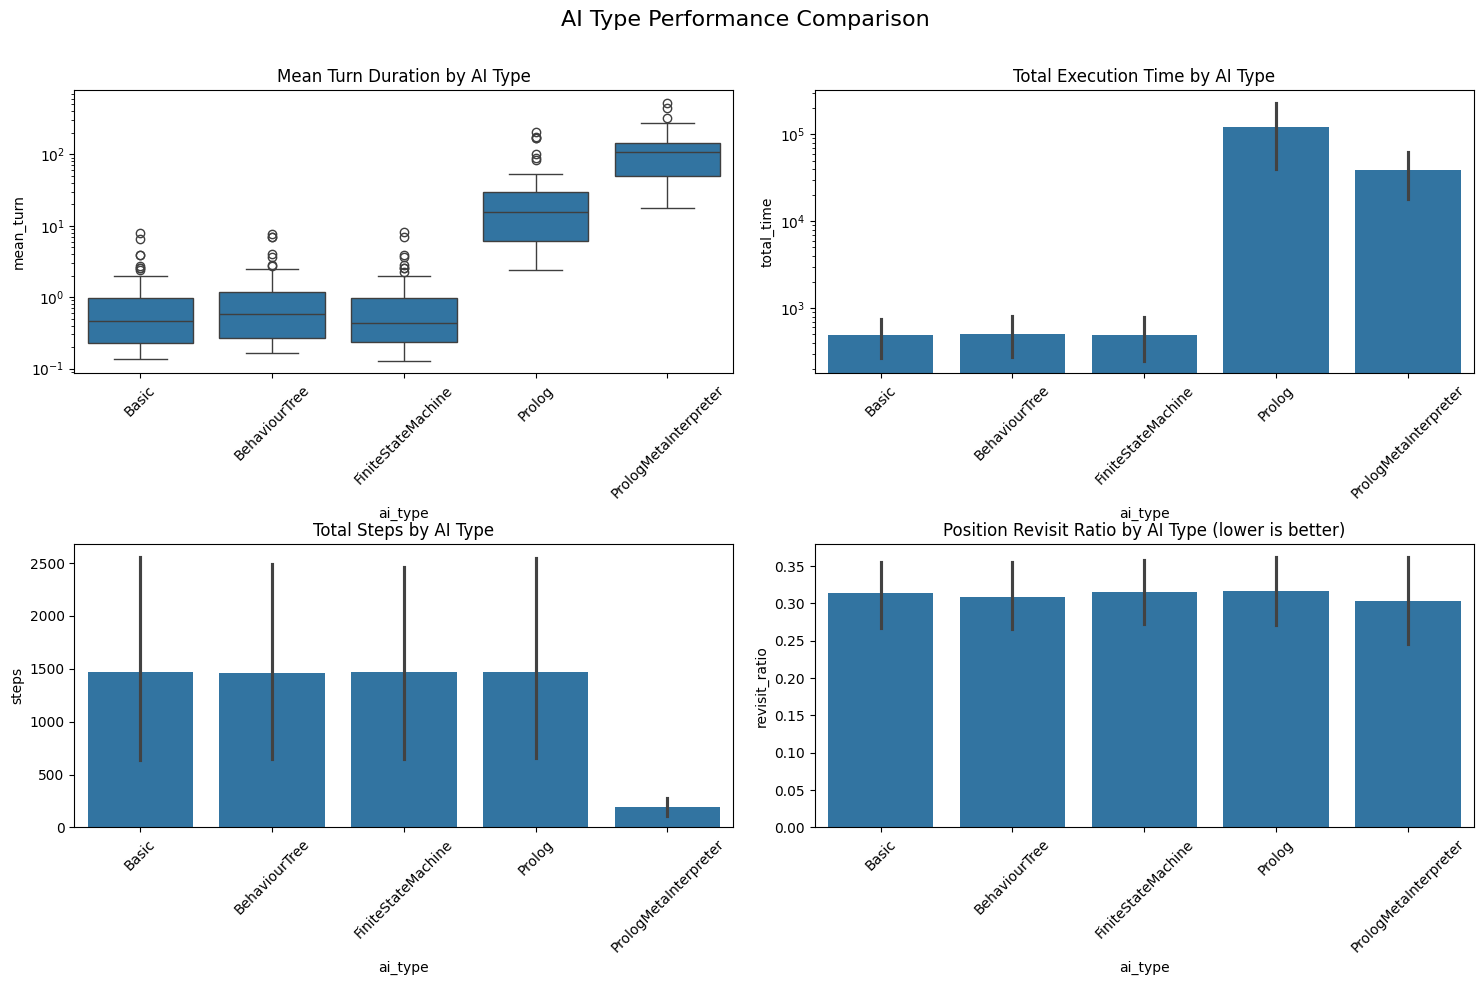

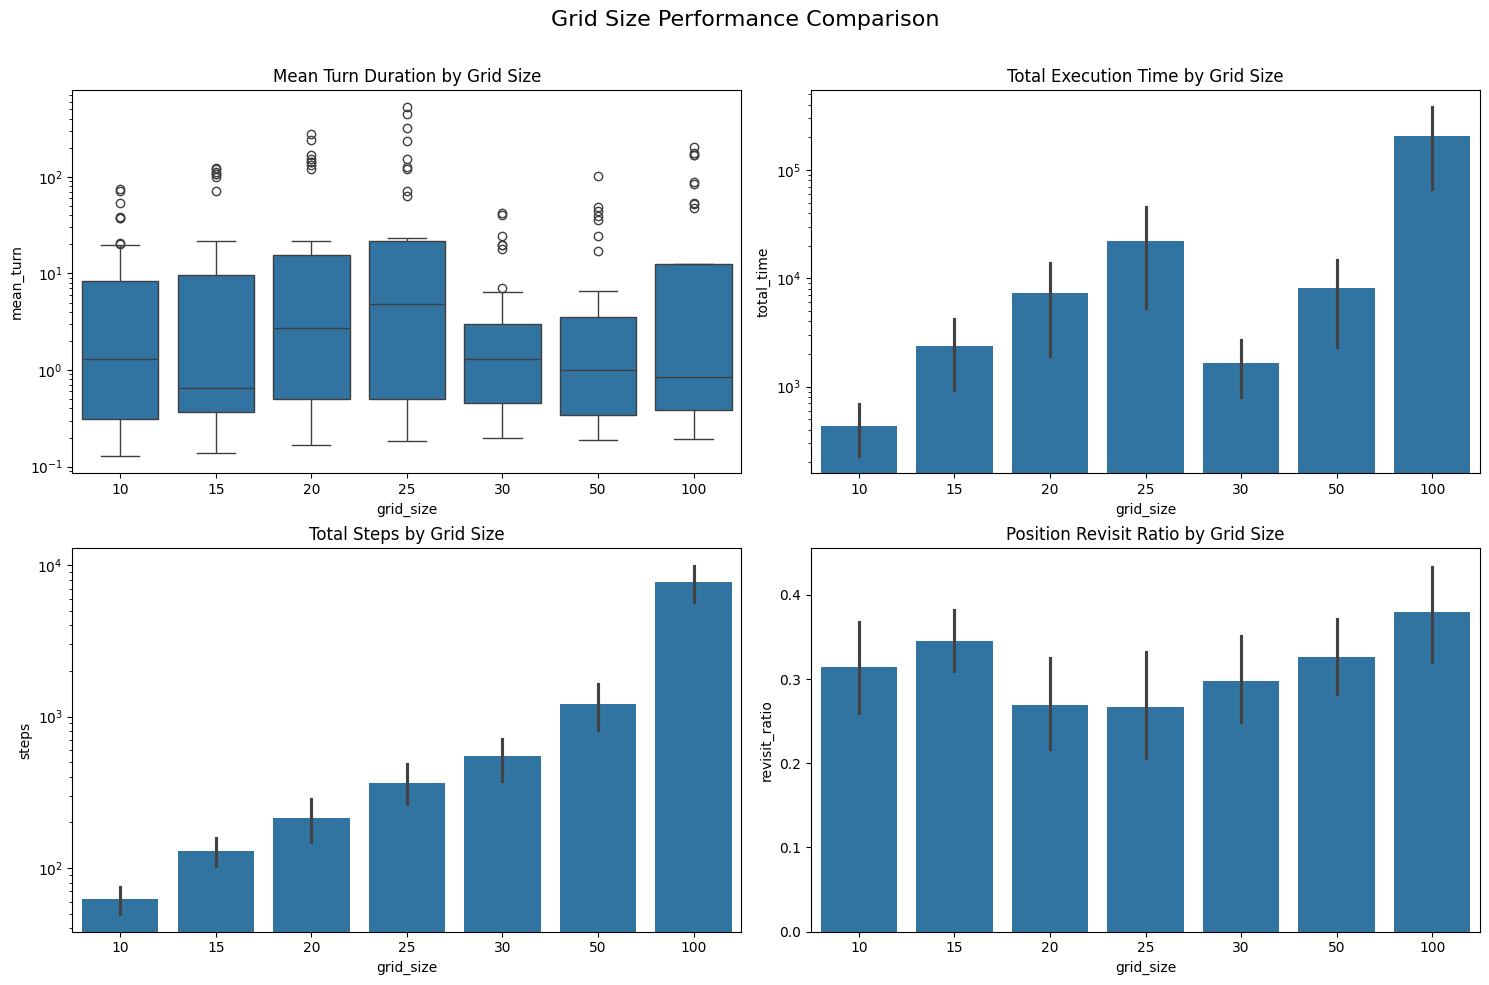

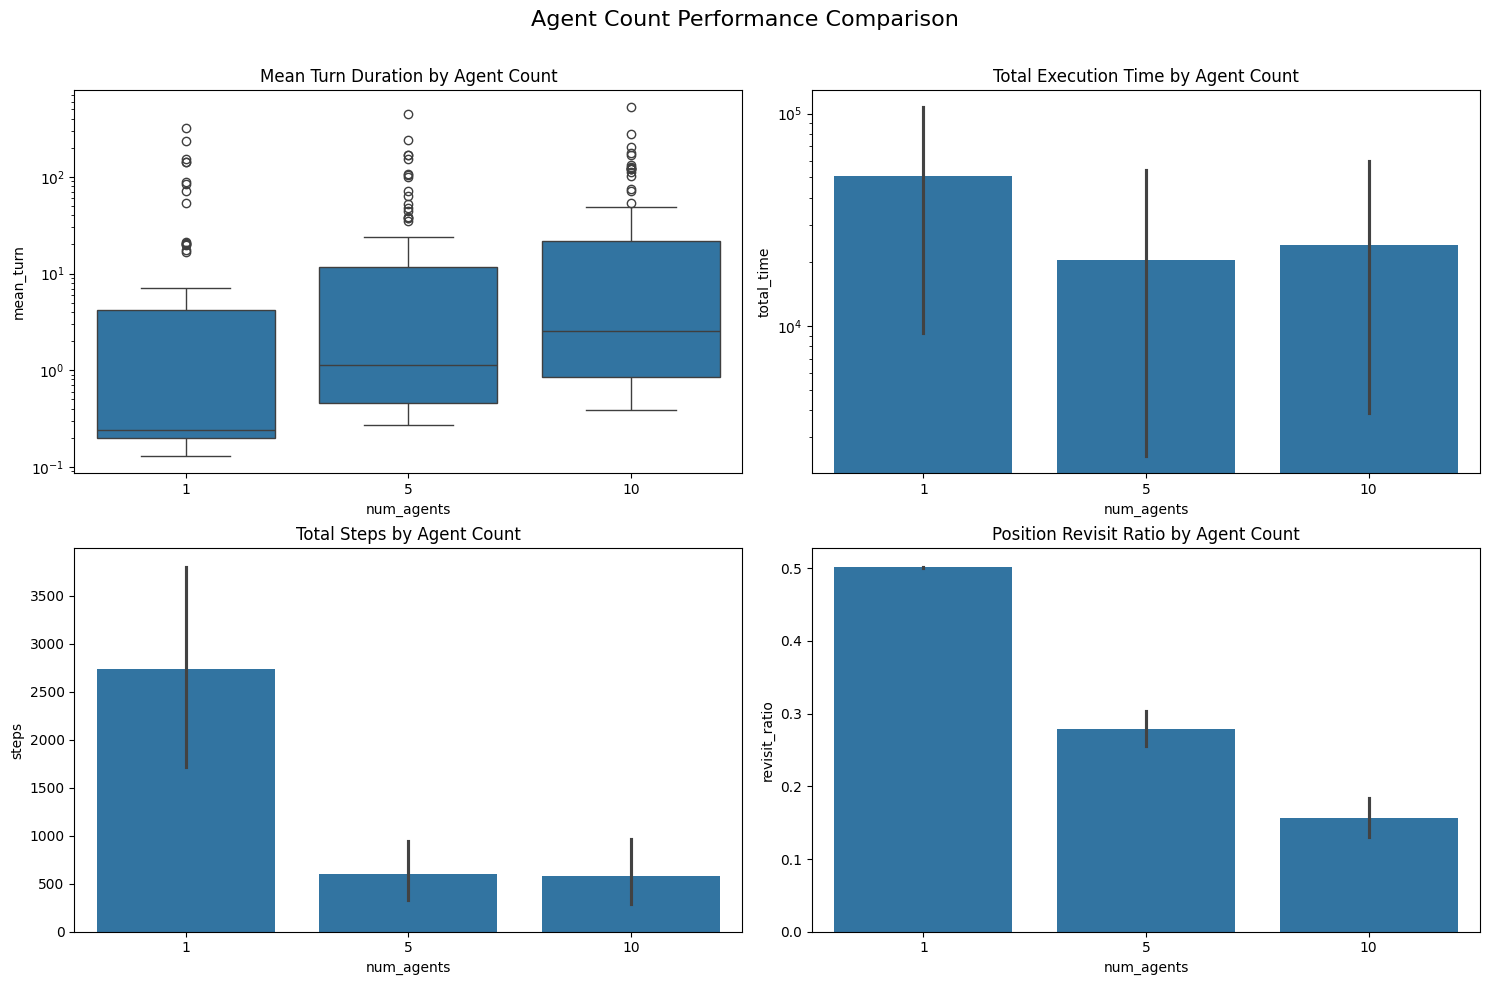

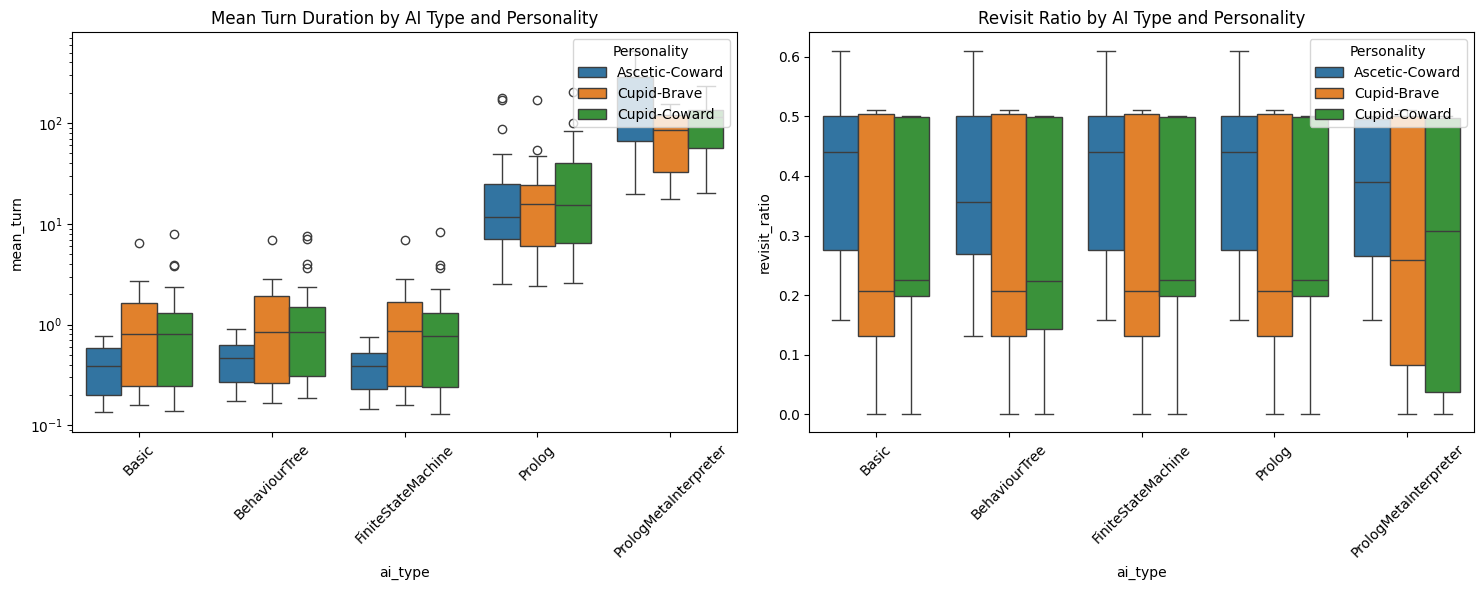

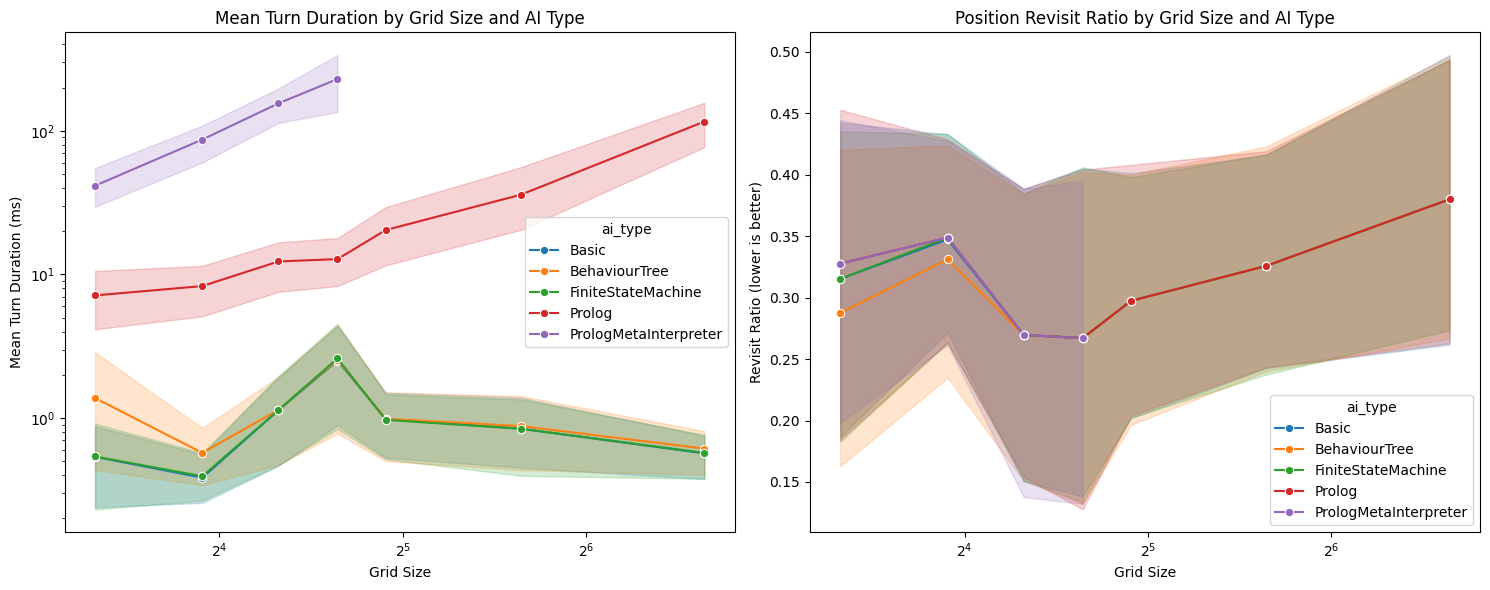

Summary of Performance Metrics by AI Type:
              ai_type  mean_turn  median_turn  total_time   steps  revisit_ratio
                Basic       1.00         0.36      488.13 1466.75           0.31
        BehaviourTree       1.16         0.40      509.90 1464.40           0.31
   FiniteStateMachine       1.01         0.36      492.50 1466.43           0.31
               Prolog      30.42        29.97   121481.64 1466.60           0.32
PrologMetaInterpreter     128.37       133.43    38451.15  193.11           0.30

Summary by Grid Size:
 grid_size  mean_turn  total_time   steps  revisit_ratio
        10      10.23      435.44   62.36           0.31
        15      19.34     2394.20  129.13           0.35
        20      34.23     7265.45  212.78           0.27
        25      49.99    21880.40  365.04           0.27
        30       5.83     1642.03  548.00           0.30
        50       9.63     8091.72 1206.44           0.33
       100      29.45   203949.32 7739.33        

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns
from glob import glob


# Keep the existing functions
def load_json_data(file_path):
    """Load data from a JSON file."""
    with open(file_path, "r") as f:
        return json.load(f)


def get_turn_duration_stats(data):
    """Extract turn duration statistics from game data."""
    turn_durations = data[0]["turnDuration"]
    return {
        "mean": np.mean(turn_durations),
        "median": np.median(turn_durations),
        "min": np.min(turn_durations),
        "max": np.max(turn_durations),
        "std": np.std(turn_durations),
        "total": np.sum(turn_durations),
        "count": len(turn_durations),
    }


def analyze_agent_actions(data):
    """Analyze the frequency of different actions taken by agent."""
    actions = data[1]["actions"]
    action_counts = {}
    for action in actions:
        if action in action_counts:
            action_counts[action] += 1
        else:
            action_counts[action] = 1
    return action_counts


# Define function to calculate movement efficiency
def calculate_movement_efficiency(positions):
    total_steps = len(positions) - 1
    unique_positions = len(set((pos["x"], pos["y"]) for pos in positions))
    revisit_ratio = 1 - (unique_positions / len(positions))
    return {
        "total_steps": total_steps,
        "unique_positions": unique_positions,
        "revisit_ratio": revisit_ratio,
    }


# Function to parse file name to extract metadata
def parse_filename(filename):
    # Using regex to extract parts from filename
    pattern = r"(\d+)x\d+-(\d+)a-\d+wp-\d+g-(\w+)-(\w+)-(\w+).json"
    match = re.search(pattern, filename)
    if match:
        grid_size = match.group(1)
        num_agents = match.group(2)
        trait1 = match.group(3)
        trait2 = match.group(4)
        ai_type = match.group(5)
        return {
            "grid_size": int(grid_size),
            "num_agents": int(num_agents),
            "trait1": trait1,
            "trait2": trait2,
            "ai_type": ai_type,
            "personality": f"{trait1}-{trait2}",
        }
    return None


# Load data from all grid sizes
all_data = {}
metadata = []

# Process files from all grid sizes
for grid_size in [10, 15, 20, 25, 30, 50, 100]:
    # Use glob to find all .json files in each grid size directory
    grid_file_paths = glob(f"{grid_size}x{grid_size}/*.json")
    
    # Sort the file paths for consistent processing
    grid_file_paths.sort()
    
    print(f"Found {len(grid_file_paths)} files in {grid_size}x{grid_size} directory")
    
    # Process files and extract metadata
    for file_path in grid_file_paths:
        meta = parse_filename(file_path)
        if meta:
            data = load_json_data(file_path)

            # Collect stats
            turn_stats = get_turn_duration_stats(data)
            action_counts = analyze_agent_actions(data)
            movement_efficiency = calculate_movement_efficiency(data[1]["positions"])

            # Store all info
            file_key = (
                f"{meta['grid_size']}x{meta['grid_size']}-{meta['num_agents']}a-{meta['trait1']}-{meta['trait2']}-{meta['ai_type']}"
            )
            all_data[file_key] = {
                "data": data,
                "meta": meta,
                "stats": {
                    "turn_stats": turn_stats,
                    "action_counts": action_counts,
                    "movement_efficiency": movement_efficiency,
                },
            }

            # Add stats to metadata for DataFrame
            meta_entry = {
                **meta,
                "mean_turn": turn_stats["mean"],
                "median_turn": turn_stats["median"],
                "max_turn": turn_stats["max"],
                "total_time": turn_stats["total"],
                "steps": movement_efficiency["total_steps"],
                "revisit_ratio": movement_efficiency["revisit_ratio"],
                "actions": len(action_counts),
            }
            metadata.append(meta_entry)

# Create DataFrame for easier analysis
df = pd.DataFrame(metadata)
print(f"Processed a total of {len(metadata)} files across all grid sizes")
print(f"Grid sizes in dataset: {[int(size) for size in sorted(df['grid_size'].unique())]}")
print(f"AI types in dataset: {sorted(df['ai_type'].unique())}")
print(f"Personalities in dataset: {sorted(df['personality'].unique())}")

# Analysis by AI type
plt.figure(figsize=(15, 10))

# Turn duration by AI type
plt.subplot(2, 2, 1)
sns.boxplot(x="ai_type", y="mean_turn", data=df)
plt.title("Mean Turn Duration by AI Type")
plt.yscale("log")  # Log scale to handle large differences
plt.xticks(rotation=45)

# Total time by AI type
plt.subplot(2, 2, 2)
sns.barplot(x="ai_type", y="total_time", data=df)
plt.title("Total Execution Time by AI Type")
plt.yscale("log")
plt.xticks(rotation=45)

# Steps by AI type
plt.subplot(2, 2, 3)
sns.barplot(x="ai_type", y="steps", data=df)
plt.title("Total Steps by AI Type")
plt.xticks(rotation=45)

# Revisit ratio by AI type
plt.subplot(2, 2, 4)
sns.barplot(x="ai_type", y="revisit_ratio", data=df)
plt.title("Position Revisit Ratio by AI Type (lower is better)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("AI Type Performance Comparison", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Analysis by grid size
plt.figure(figsize=(15, 10))

# Turn duration by grid size
plt.subplot(2, 2, 1)
sns.boxplot(x="grid_size", y="mean_turn", data=df)
plt.title("Mean Turn Duration by Grid Size")
plt.yscale("log")

# Total time by grid size
plt.subplot(2, 2, 2)
sns.barplot(x="grid_size", y="total_time", data=df)
plt.title("Total Execution Time by Grid Size")
plt.yscale("log")

# Steps by grid size
plt.subplot(2, 2, 3)
sns.barplot(x="grid_size", y="steps", data=df)
plt.title("Total Steps by Grid Size")
plt.yscale("log")

# Revisit ratio by grid size
plt.subplot(2, 2, 4)
sns.barplot(x="grid_size", y="revisit_ratio", data=df)
plt.title("Position Revisit Ratio by Grid Size")

plt.tight_layout()
plt.suptitle("Grid Size Performance Comparison", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Analysis by number of agents
plt.figure(figsize=(15, 10))

# Turn duration by agent count
plt.subplot(2, 2, 1)
sns.boxplot(x="num_agents", y="mean_turn", data=df)
plt.title("Mean Turn Duration by Agent Count")
plt.yscale("log")

# Total time by agent count
plt.subplot(2, 2, 2)
sns.barplot(x="num_agents", y="total_time", data=df)
plt.title("Total Execution Time by Agent Count")
plt.yscale("log")

# Steps by agent count
plt.subplot(2, 2, 3)
sns.barplot(x="num_agents", y="steps", data=df)
plt.title("Total Steps by Agent Count")

# Revisit ratio by agent count
plt.subplot(2, 2, 4)
sns.barplot(x="num_agents", y="revisit_ratio", data=df)
plt.title("Position Revisit Ratio by Agent Count")

plt.tight_layout()
plt.suptitle("Agent Count Performance Comparison", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Interaction between AI type and personality
plt.figure(figsize=(15, 6))

# Mean turn duration
plt.subplot(1, 2, 1)
sns.boxplot(x="ai_type", y="mean_turn", hue="personality", data=df)
plt.title("Mean Turn Duration by AI Type and Personality")
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Personality", loc="upper right")

# Revisit ratio
plt.subplot(1, 2, 2)
sns.boxplot(x="ai_type", y="revisit_ratio", hue="personality", data=df)
plt.title("Revisit Ratio by AI Type and Personality")
plt.xticks(rotation=45)
plt.legend(title="Personality", loc="upper right")

plt.tight_layout()
plt.show()

# Interaction between grid size and AI type
plt.figure(figsize=(15, 6))

# Mean turn duration by grid size and AI type
plt.subplot(1, 2, 1)
sns.lineplot(x="grid_size", y="mean_turn", hue="ai_type", data=df, marker="o")
plt.title("Mean Turn Duration by Grid Size and AI Type")
plt.xscale("log", base=2)  # Log scale for grid size
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Mean Turn Duration (ms)")

# Revisit ratio by grid size and AI type
plt.subplot(1, 2, 2)
sns.lineplot(x="grid_size", y="revisit_ratio", hue="ai_type", data=df, marker="o")
plt.title("Position Revisit Ratio by Grid Size and AI Type")
plt.xscale("log", base=2)  # Log scale for grid size
plt.xlabel("Grid Size")
plt.ylabel("Revisit Ratio (lower is better)")

plt.tight_layout()
plt.show()

# Create summary table
print("Summary of Performance Metrics by AI Type:")
ai_summary = (
    df.groupby("ai_type")
    .agg(
        {
            "mean_turn": "mean",
            "median_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
            "revisit_ratio": "mean",
        }
    )
    .reset_index()
)

print(ai_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Grid Size:")
grid_summary = (
    df.groupby("grid_size")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
            "revisit_ratio": "mean",
        }
    )
    .reset_index()
)

print(grid_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Number of Agents:")
agent_summary = (
    df.groupby("num_agents")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
            "revisit_ratio": "mean",
        }
    )
    .reset_index()
)

print(agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Personality:")
personality_summary = (
    df.groupby("personality")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
            "revisit_ratio": "mean",
        }
    )
    .reset_index()
)

print(personality_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))


### Baseline Performance Analysis Results

Our updated analysis of agent performance in the Wumpus World environment, incorporating all available files, reveals refined insights into the performance of different AI implementations. Below are the key findings:

#### AI Type Performance Comparison

1. **Computational Efficiency**:
    - Basic, Finite State Machine, and Behavior Tree agents exhibit similar performance, with mean turn durations around 1ms.
    - Prolog agents are significantly slower, with a mean turn duration of 30.42ms.
    - Prolog Meta Interpreter agents are the slowest, averaging 128.37ms per turn.

2. **Exploration Behavior**:
    - All AI types show comparable step counts (~1466) and revisit ratios (~0.31), except for Prolog Meta Interpreter agents, which take significantly fewer steps (193.11) with a slightly lower revisit ratio (0.30).

3. **Total Processing Time**:
    - Basic implementations complete scenarios fastest : 488.13ms total.
    - Prolog implementations take significantly longer : 121 481.64ms.
    - Prolog Meta Interpreter implementations require 38 451.15ms.

#### Grid Size Impact

1. **Scaling with Grid Size**:
    - Mean turn duration increases with grid size, peaking at 49.99ms for 25x25 grids before decreasing for larger grids.
    - Total time and steps increase consistently with grid size, with the largest grid (100x100) requiring 203,949.32ms and 7,739 steps.
    - Revisit ratio decreases for medium-sized grids (20x20, 25x25) but increases for the largest grids (50x50, 100x100).

#### Agent Number Impact

1. **Processing Overhead**:
    - Single-agent configurations have the highest mean turn duration (15.82ms) and total time (50 762.82ms).
    - Multi-agent configurations (5 or 10 agents) reduce revisit ratios significantly (0.28 and 0.16, respectively), indicating better exploration efficiency.

2. **Exploration Efficiency**:
    - 10-agent configurations complete scenarios with fewer steps (581.96) compared to single-agent setups (2736.72).

#### Personality Influence

1. **Processing Requirements**:
    - Ascetic-Coward personality combination exhibits the highest computational demands (32.20ms/turn).
    - Cupid-Brave agents are the most efficient, with the lowest mean turn duration (16.81ms).

2. **Exploration Patterns**:
    - Ascetic-Coward agents take the most steps (2070.79) with the highest revisit ratio (0.39).
    - Cupid-Brave agents are the most efficient, with fewer steps (754.85) and a lower revisit ratio (0.27).

These updated findings highlight the trade-offs between computational efficiency and exploration behavior, with grid size, agent number, and personality traits significantly influencing performance metrics.

## 2. Scaling Performance Analysis

This section provides a detailed analysis of how performance metrics scale with grid size across different AI types. The visualizations and metrics highlight the computational and behavioral efficiency of agents as the environment complexity increases.

### Key Insights

1. **Scaling of Mean Turn Duration**:
    - Line plots show how the average time per turn scales with grid size for each AI type.
    - A log-log scale is used to visualize growth patterns, with linear scaling as a reference.

2. **Scaling of Steps Taken**:
    - The total number of steps taken by agents is analyzed across grid sizes.
    - Superlinear growth in steps indicates inefficiencies in exploration strategies.

3. **Scaling of Revisit Ratio**:
    - The proportion of revisited positions is compared across grid sizes.
    - Lower revisit ratios indicate more efficient exploration.

4. **Heatmaps of Performance Metrics**:
    - Heatmaps provide a grid-size-wise comparison of mean turn duration, steps, and revisit ratios for each AI type.
    - These visualizations highlight the relative performance of AI types at different scales.

5. **Efficiency Analysis**:
    - A composite efficiency score is calculated for each AI type and grid size, combining normalized metrics (mean turn, steps, revisit ratio, and total time).
    - The most efficient AI type for each grid size is identified and visualized.

6. **Impact of Personality and Agent Count**:
    - Additional analyses explore how personality traits and the number of agents influence scaling behavior.
    - These insights reveal trade-offs between computational efficiency and exploration strategies.

The results emphasize the importance of scalability in AI design, with significant differences in performance across AI types, grid sizes, and configurations.

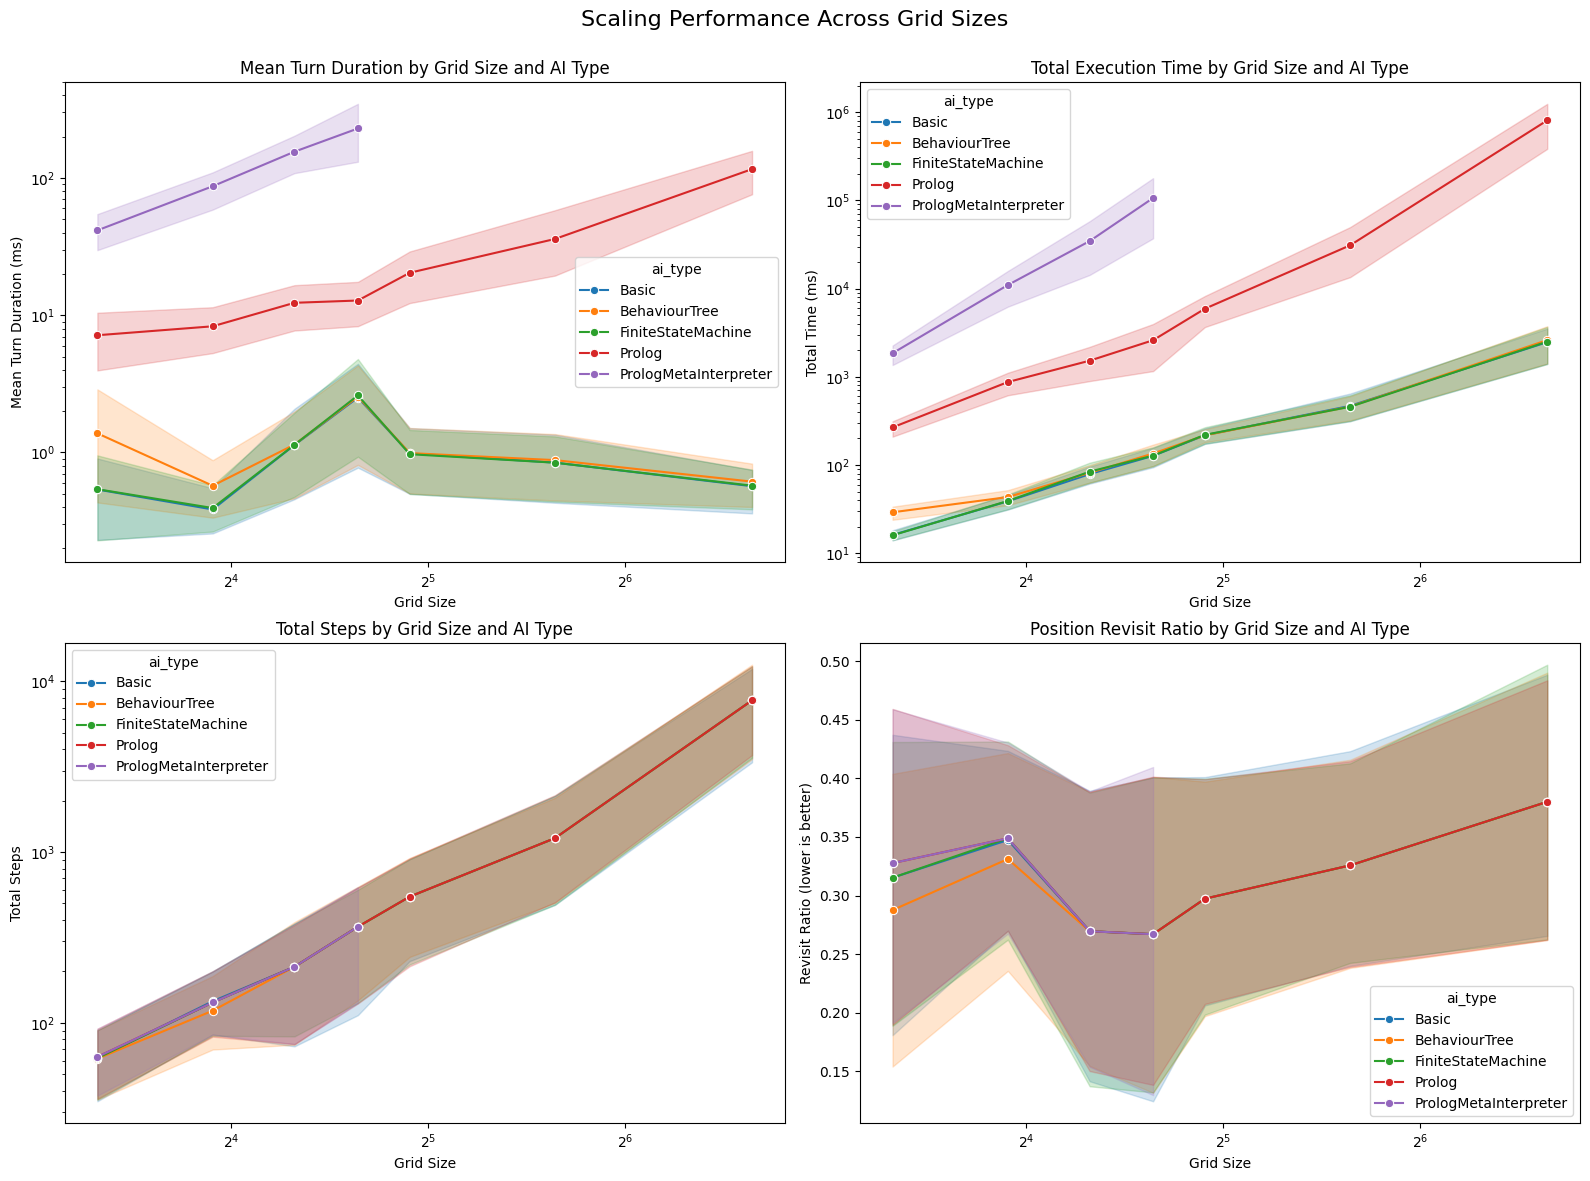

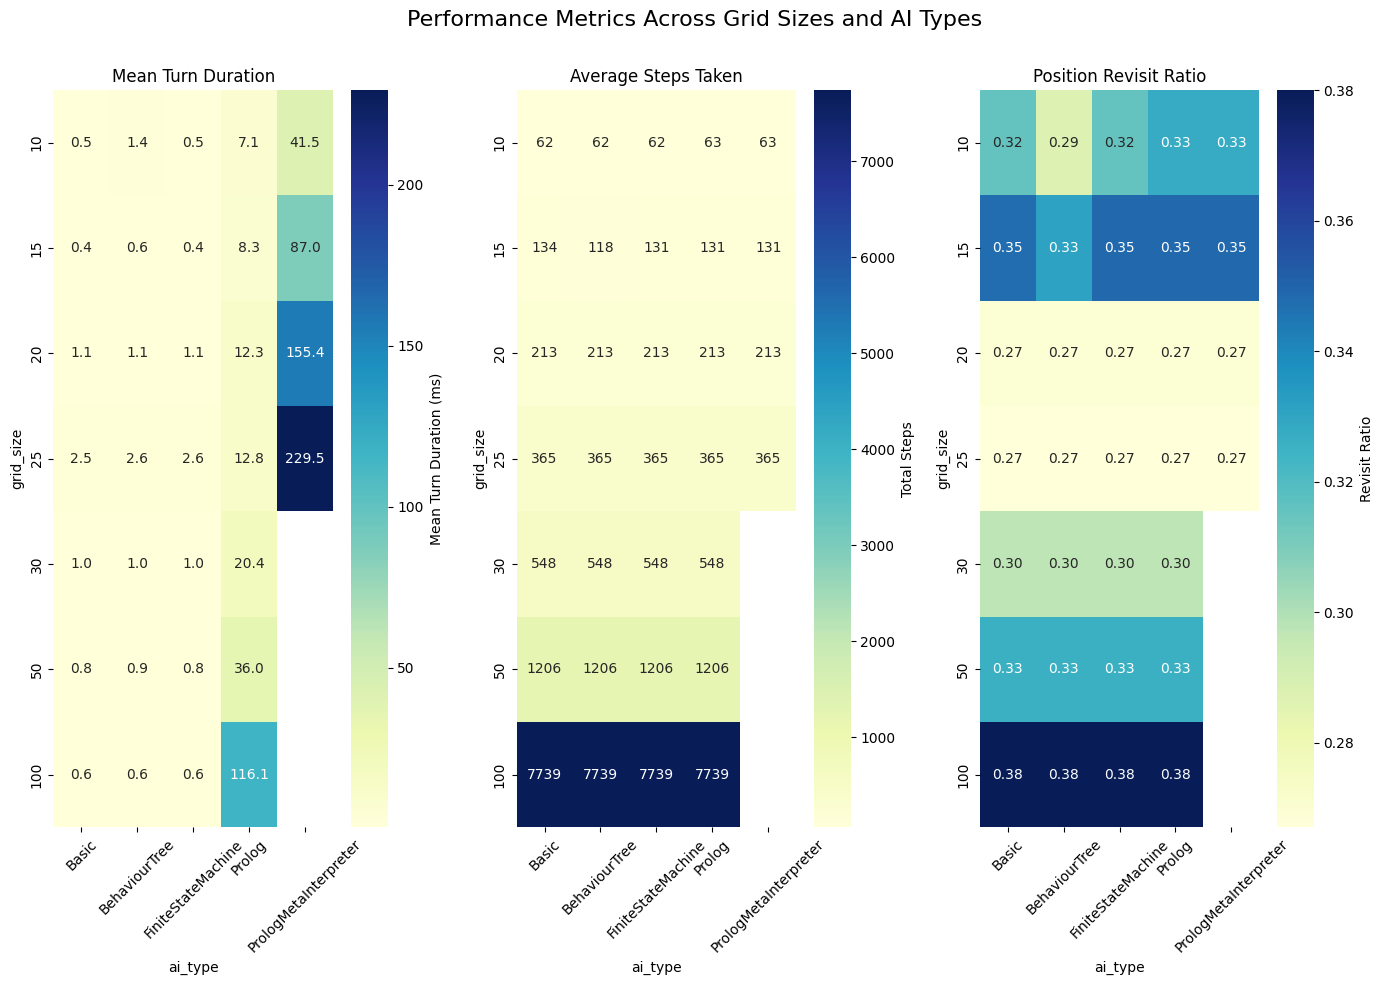

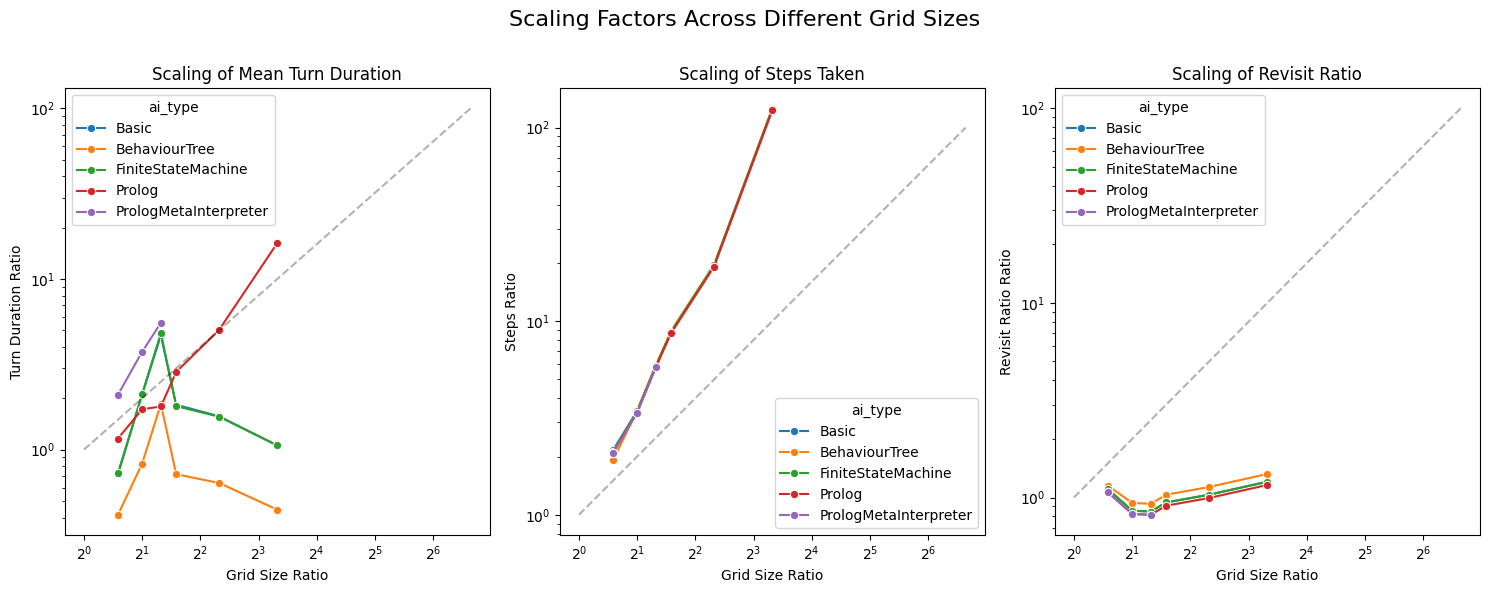

Scaling Efficiency Summary (average scaling factor by AI type):
metric                 mean_turn  revisit_ratio  steps
ai_type                                               
Basic                       0.74           0.36   4.14
BehaviourTree               0.31           0.39   4.14
FiniteStateMachine          0.75           0.36   4.13
Prolog                      0.99           0.34   4.06
PrologMetaInterpreter       1.83           0.48   1.80

Interpretation:
- A scaling factor of 1.0 indicates linear scaling (doubling grid size doubles the metric)
- Less than 1.0 is better than linear scaling (sublinear growth)
- Greater than 1.0 is worse than linear scaling (superlinear growth)


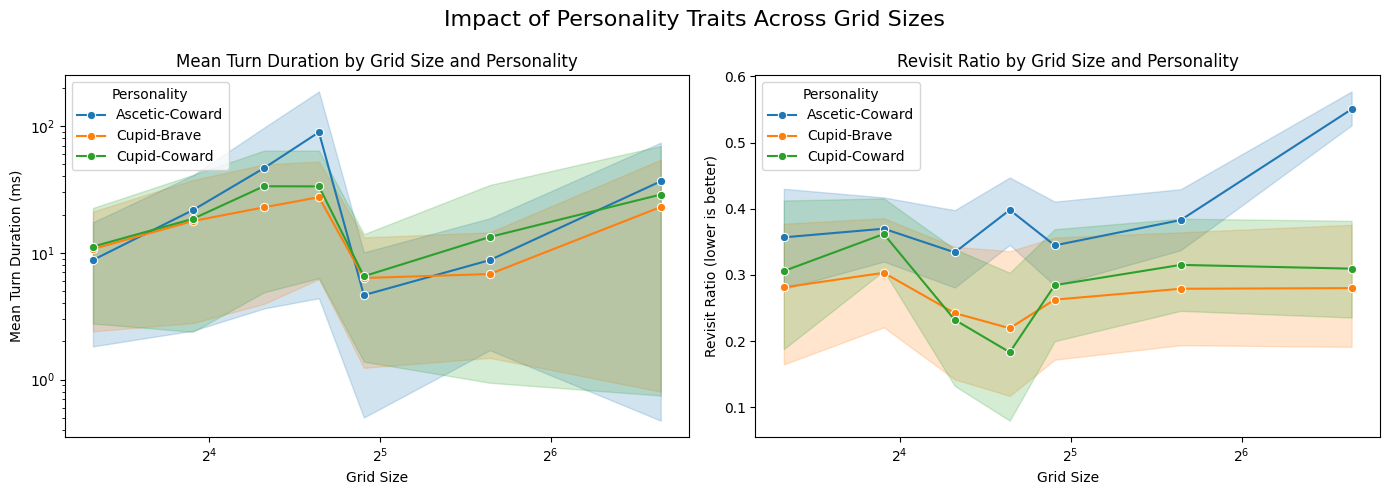

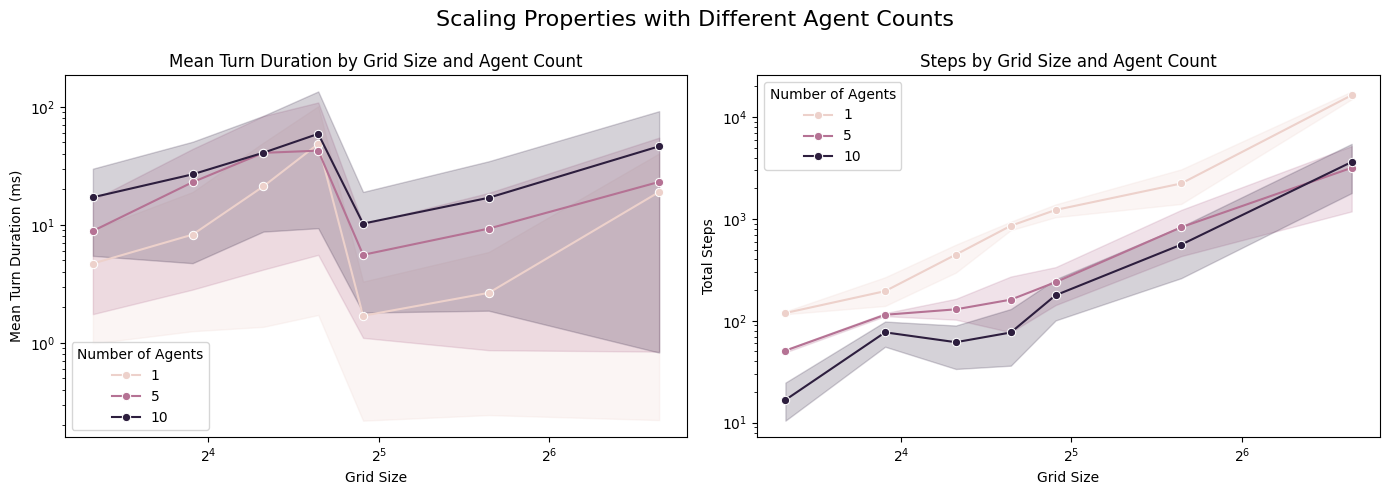

Most Efficient AI Type by Grid Size:
 grid_size            ai_type  efficiency_score
        10      BehaviourTree             0.008
        15      BehaviourTree             0.001
        20              Basic             0.000
        25              Basic             0.000
        30 FiniteStateMachine             0.000
        50 FiniteStateMachine             0.000
       100              Basic             0.000


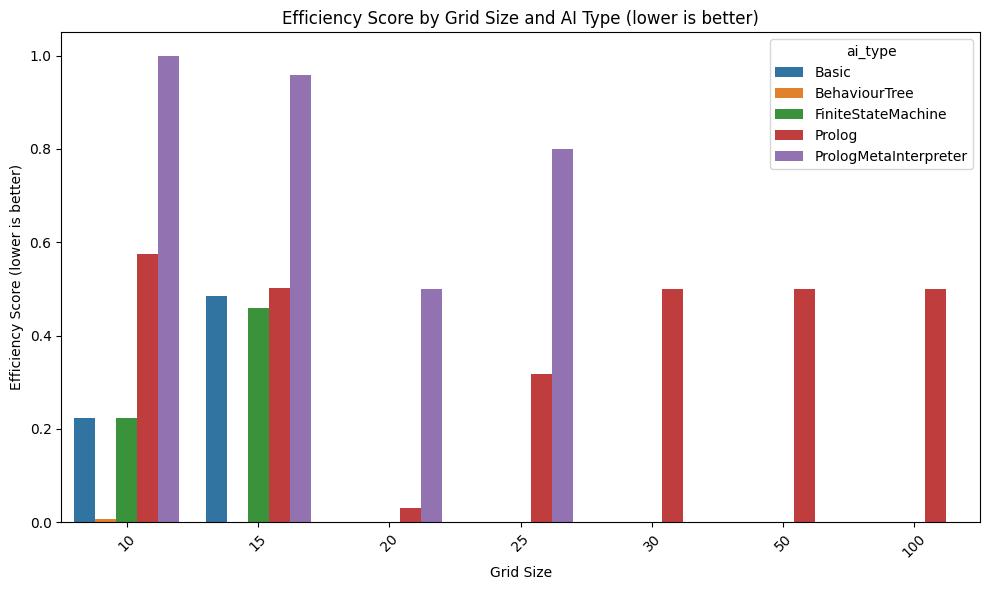

In [2]:
# Visualize scaling with grid size
plt.figure(figsize=(16, 12))

# Mean turn duration by grid size and AI type
plt.subplot(2, 2, 1)
sns.lineplot(x="grid_size", y="mean_turn", hue="ai_type", data=df, marker="o")
plt.title("Mean Turn Duration by Grid Size and AI Type")
plt.xscale("log", base=2)  # Use log scale with base 2 for better visualization
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Mean Turn Duration (ms)")

# Total time by grid size and AI type
plt.subplot(2, 2, 2)
sns.lineplot(x="grid_size", y="total_time", hue="ai_type", data=df, marker="o")
plt.title("Total Execution Time by Grid Size and AI Type")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Total Time (ms)")

# Steps by grid size and AI type
plt.subplot(2, 2, 3)
sns.lineplot(x="grid_size", y="steps", hue="ai_type", data=df, marker="o")
plt.title("Total Steps by Grid Size and AI Type")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Total Steps")

# Revisit ratio by grid size and AI type
plt.subplot(2, 2, 4)
sns.lineplot(x="grid_size", y="revisit_ratio", hue="ai_type", data=df, marker="o")
plt.title("Position Revisit Ratio by Grid Size and AI Type")
plt.xscale("log", base=2)
plt.xlabel("Grid Size")
plt.ylabel("Revisit Ratio (lower is better)")

plt.tight_layout()
plt.suptitle("Scaling Performance Across Grid Sizes", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

# Heatmap of performance metrics by grid size and AI type
plt.figure(figsize=(14, 10))

# Pivot data for heatmaps
pivot_time = df.pivot_table(
    index="grid_size", columns="ai_type", values="mean_turn", aggfunc="mean"
)
pivot_steps = df.pivot_table(
    index="grid_size", columns="ai_type", values="steps", aggfunc="mean"
)
pivot_revisit = df.pivot_table(
    index="grid_size", columns="ai_type", values="revisit_ratio", aggfunc="mean"
)

# Time heatmap
plt.subplot(1, 3, 1)
sns.heatmap(
    pivot_time,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={"label": "Mean Turn Duration (ms)"},
)
plt.title("Mean Turn Duration")
plt.xticks(rotation=45)

# Steps heatmap
plt.subplot(1, 3, 2)
sns.heatmap(
    pivot_steps, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "Total Steps"}
)
plt.title("Average Steps Taken")
plt.xticks(rotation=45)

# Revisit ratio heatmap
plt.subplot(1, 3, 3)
sns.heatmap(
    pivot_revisit,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={"label": "Revisit Ratio"},
)
plt.title("Position Revisit Ratio")
plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("Performance Metrics Across Grid Sizes and AI Types", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Analyze scaling efficiency
# Calculate how performance metrics scale with grid size
scaling_analysis = (
    df.groupby(["ai_type", "grid_size"])
    .agg({"mean_turn": "mean", "steps": "mean", "revisit_ratio": "mean"})
    .reset_index()
)

# Calculate growth rates
scaling_results = []
ai_types = scaling_analysis["ai_type"].unique()

for ai in ai_types:
    ai_data = scaling_analysis[scaling_analysis["ai_type"] == ai].sort_values(
        "grid_size"
    )
    
    # Skip AI types with fewer than 2 data points (can't calculate scaling)
    if len(ai_data) < 2:
        continue

    for metric in ["mean_turn", "steps", "revisit_ratio"]:
        base_grid = ai_data.iloc[0]["grid_size"]
        base_value = ai_data.iloc[0][metric]
        
        # Skip if base value is zero (can't calculate ratio)
        if base_value == 0:
            continue

        for i in range(1, len(ai_data)):
            current_grid = ai_data.iloc[i]["grid_size"]
            current_value = ai_data.iloc[i][metric]

            grid_ratio = current_grid / base_grid
            value_ratio = current_value / base_value
            scaling_factor = value_ratio / grid_ratio

            scaling_results.append(
                {
                    "ai_type": ai,
                    "metric": metric,
                    "base_grid": base_grid,
                    "current_grid": current_grid,
                    "grid_ratio": grid_ratio,
                    "value_ratio": value_ratio,
                    "scaling_factor": scaling_factor,
                }
            )

scaling_df = pd.DataFrame(scaling_results)

# Only proceed if we have scaling data
if not scaling_df.empty:
    # Visualize scaling factors
    plt.figure(figsize=(15, 6))
    
    # Scaling of mean turn duration
    plt.subplot(1, 3, 1)
    sns.lineplot(
        x="grid_ratio",
        y="value_ratio",
        hue="ai_type",
        data=scaling_df[scaling_df["metric"] == "mean_turn"],
        marker="o",
    )
    plt.title("Scaling of Mean Turn Duration")
    plt.xscale("log", base=2)  # Consistent with grid ratio scale
    plt.yscale("log")
    plt.xlabel("Grid Size Ratio")
    plt.ylabel("Turn Duration Ratio")
    plt.plot([1, 100], [1, 100], "k--", alpha=0.3)  # Linear scaling reference
    
    # Scaling of steps
    plt.subplot(1, 3, 2)
    sns.lineplot(
        x="grid_ratio",
        y="value_ratio",
        hue="ai_type",
        data=scaling_df[scaling_df["metric"] == "steps"],
        marker="o",
    )
    plt.title("Scaling of Steps Taken")
    plt.xscale("log", base=2)  # Consistent with grid ratio scale
    plt.yscale("log")
    plt.xlabel("Grid Size Ratio")
    plt.ylabel("Steps Ratio")
    plt.plot([1, 100], [1, 100], "k--", alpha=0.3)  # Linear scaling reference
    
    # Scaling of revisit ratio
    plt.subplot(1, 3, 3)
    sns.lineplot(
        x="grid_ratio",
        y="value_ratio",
        hue="ai_type",
        data=scaling_df[scaling_df["metric"] == "revisit_ratio"],
        marker="o",
    )
    plt.title("Scaling of Revisit Ratio")
    plt.xscale("log", base=2)  # Consistent with grid ratio scale
    plt.yscale("log")
    plt.xlabel("Grid Size Ratio")
    plt.ylabel("Revisit Ratio Ratio")
    plt.plot([1, 100], [1, 100], "k--", alpha=0.3)  # Linear scaling reference
    
    plt.tight_layout()
    plt.suptitle("Scaling Factors Across Different Grid Sizes", fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Print summary of scaling efficiency
    print("Scaling Efficiency Summary (average scaling factor by AI type):")
    scaling_summary = (
        scaling_df.groupby(["ai_type", "metric"])["scaling_factor"].mean().reset_index()
    )
    scaling_summary_pivot = scaling_summary.pivot(
        index="ai_type", columns="metric", values="scaling_factor"
    )
    print(scaling_summary_pivot.to_string(float_format=lambda x: f"{x:.2f}"))
    
    print("\nInterpretation:")
    print("- A scaling factor of 1.0 indicates linear scaling (doubling grid size doubles the metric)")
    print("- Less than 1.0 is better than linear scaling (sublinear growth)")
    print("- Greater than 1.0 is worse than linear scaling (superlinear growth)")
else:
    print("Not enough data to calculate scaling factors.")

# Add new analysis: Performance by agent personality and grid size
plt.figure(figsize=(14, 5))

# Mean turn duration by grid size and personality
plt.subplot(1, 2, 1)
sns.lineplot(x="grid_size", y="mean_turn", hue="personality", data=df, marker="o")
plt.title("Mean Turn Duration by Grid Size and Personality")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Mean Turn Duration (ms)")
plt.legend(title="Personality")

# Revisit ratio by grid size and personality
plt.subplot(1, 2, 2)
sns.lineplot(x="grid_size", y="revisit_ratio", hue="personality", data=df, marker="o")
plt.title("Revisit Ratio by Grid Size and Personality")
plt.xscale("log", base=2)
plt.xlabel("Grid Size")
plt.ylabel("Revisit Ratio (lower is better)")
plt.legend(title="Personality")

plt.tight_layout()
plt.suptitle("Impact of Personality Traits Across Grid Sizes", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

# Add new analysis: Compare grid size impact across different number of agents
plt.figure(figsize=(14, 5))

# Mean turn duration by grid size and agent count
plt.subplot(1, 2, 1)
sns.lineplot(x="grid_size", y="mean_turn", hue="num_agents", data=df, marker="o")
plt.title("Mean Turn Duration by Grid Size and Agent Count")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Mean Turn Duration (ms)")
plt.legend(title="Number of Agents")

# Steps by grid size and agent count
plt.subplot(1, 2, 2)
sns.lineplot(x="grid_size", y="steps", hue="num_agents", data=df, marker="o")
plt.title("Steps by Grid Size and Agent Count")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Total Steps")
plt.legend(title="Number of Agents")

plt.tight_layout()
plt.suptitle("Scaling Properties with Different Agent Counts", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

# Add efficiency analysis - which AI type is most efficient for each grid size?
efficiency_metrics = df.groupby(["grid_size", "ai_type"]).agg({
    "mean_turn": "mean", 
    "steps": "mean", 
    "revisit_ratio": "mean",
    "total_time": "mean"
}).reset_index()

# Create composite efficiency score (normalized)
for grid_size in efficiency_metrics["grid_size"].unique():
    grid_data = efficiency_metrics[efficiency_metrics["grid_size"] == grid_size]
    
    # Normalize each metric in 0-1 range where 0 is best
    for metric in ["mean_turn", "steps", "revisit_ratio", "total_time"]:
        min_val = grid_data[metric].min()
        max_val = grid_data[metric].max()
        range_val = max_val - min_val
        
        if range_val > 0:  # Avoid division by zero
            efficiency_metrics.loc[grid_data.index, f"norm_{metric}"] = (grid_data[metric] - min_val) / range_val
        else:
            efficiency_metrics.loc[grid_data.index, f"norm_{metric}"] = 0

# Calculate overall efficiency score (lower is better)
efficiency_metrics["efficiency_score"] = (
    efficiency_metrics["norm_mean_turn"] * 0.3 + 
    efficiency_metrics["norm_steps"] * 0.3 + 
    efficiency_metrics["norm_revisit_ratio"] * 0.2 + 
    efficiency_metrics["norm_total_time"] * 0.2
)

# Find the most efficient AI type for each grid size
best_efficiency = efficiency_metrics.loc[efficiency_metrics.groupby("grid_size")["efficiency_score"].idxmin()]
print("Most Efficient AI Type by Grid Size:")
print(best_efficiency[["grid_size", "ai_type", "efficiency_score"]].to_string(index=False, 
                                                                     float_format=lambda x: f"{x:.3f}"))

# Visualize efficiency scores
plt.figure(figsize=(10, 6))
sns.barplot(x="grid_size", y="efficiency_score", hue="ai_type", data=efficiency_metrics)
plt.title("Efficiency Score by Grid Size and AI Type (lower is better)")
plt.xlabel("Grid Size")
plt.ylabel("Efficiency Score (lower is better)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Scaling Performance Analysis Results

#### AI Type Scaling Efficiency

1. **Mean Turn Duration**:
    - Basic, Finite State Machine, and Behavior Tree agents exhibit sublinear scaling with grid size, with scaling factors of 0.738, 0.747, and 0.307, respectively.
    - Prolog agents scale nearly linearly (0.989), while Prolog Meta Interpreter agents show superlinear growth (1.827), indicating significant inefficiencies.

2. **Steps Taken**:
    - All AI types exhibit superlinear scaling in steps, with scaling factors around 4.1 for Basic, Finite State Machine, and Behavior Tree agents.
    - Prolog Meta Interpreter agents are more efficient in scaling steps, with a factor of 1.796.

3. **Revisit Ratio**:
    - Prolog agents have the lowest revisit ratio scaling factor (0.344), indicating efficient exploration.
    - Prolog Meta Interpreter agents have the highest revisit ratio scaling factor (0.482), reflecting less efficient exploration.

#### Grid Size Impact

1. **Mean Turn Duration**:
    - Mean turn duration increases with grid size for all AI types, with Prolog Meta Interpreter agents experiencing the steepest growth.

2. **Steps Taken**:
    - The number of steps grows significantly with grid size, with the largest grid (100 x 100) requiring over 7,700 steps on average.

3. **Revisit Ratio**:
    - Revisit ratios decrease for medium-sized grids (20 x 20, 25 x 25) but increase for larger grids (50 x 50, 100 x 100), indicating exploration inefficiencies at extreme scales.

#### Personality Influence

1. **Mean Turn Duration**:
    - Cupid-Brave agents are the most efficient, with the lowest mean turn duration (16.81ms).
    - Ascetic-Coward agents are the least efficient, with a mean turn duration of 32.20ms.

2. **Steps Taken**:
    - Cupid-Brave agents take the fewest steps (754.85), while Ascetic-Coward agents take the most (2070.79).

3. **Revisit Ratio**:
    - Cupid-Brave agents have the lowest revisit ratio (0.27), indicating efficient exploration.
    - Ascetic-Coward agents have the highest revisit ratio (0.39), reflecting less efficient exploration.

#### Efficiency Summary

- Basic, Finite State Machine, and Behavior Tree agents demonstrate better scaling efficiency compared to Prolog and Prolog Meta Interpreter agents.
- Cupid-Brave personality traits consistently outperform others in terms of computational and exploration efficiency.
- Larger grid sizes and higher agent counts introduce significant computational overhead, particularly for Prolog-based agents.